# Train siamese style U-Net model

## Import libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
#os.chdir('..')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

# Reproducibility
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

EXPERIMENT_NAME = "coin_unet_isic2018"

ROOT_DIR = os.path.abspath(".")
LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))
    
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

cuda:0


## Load data

Download ISIC-2018 lesion segmentation dataset from https://challenge.isic-archive.com/data/

In [4]:
class ISIC2018_dataloader(Dataset):
    def __init__(self, data_folder, is_train=True):
        self.is_train = is_train
        self._data_folder = data_folder
        self.build_dataset()

    def build_dataset(self):
        self._input_folder = os.path.join(self._data_folder, 'ISIC2018_Task1-2_Training_Input')
        self._label_folder = os.path.join(self._data_folder, 'ISIC2018_Task1_Training_GroundTruth')
        self._scribbles_folder = os.path.join(self._data_folder, 'SCRIBBLES')
        self._images = sorted(glob.glob(self._input_folder + "/*.jpg"))
        self._labels = sorted(glob.glob(self._label_folder + "/*.png"))
        self._scribbles = sorted(glob.glob(self._scribbles_folder + "/*.png"))
        
        self.train_images, self.test_images, self.train_labels, self.test_labels, self.train_scribbles, self.test_scribbles = train_test_split(self._images, 
                                                                                                    self._labels,
                                                                                                    self._scribbles[:len(self._images)],
                                                                                                    test_size=0.2, shuffle=False, random_state=0)

        
    def __len__(self):
        if self.is_train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self, idx):
        
        if self.is_train:
            img_path = self.train_images[idx]
            mask_path = self.train_labels[idx]
            scribble_path = self._scribbles[np.random.randint(12000)] # pick randomly from scribbles
        else:
            img_path = self.test_images[idx]
            mask_path = self.test_labels[idx]
            scribble_path = self._scribbles[idx]
            
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('P')
        scribble = Image.open(scribble_path).convert('P')
        
        transforms_image = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop((256,256)),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])
        
        transforms_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.CenterCrop((256,256)),
                                             transforms.ToTensor()])
        
        image = transforms_image(image)
        mask = transforms_mask(mask)
        scribble = transforms_mask(scribble)
        
        
        # Partial image
        
        #partial_image1 = image * mask * cmask
        #partial_image2 = image * cmask * (1 - mask)
        
        partial_image1 = image * scribble
        partial_image2 = image * (1 - scribble)
        
        
        sample = {'image': image, 
                  'mask': mask, 
                  'partial_image1': partial_image1,
                  'partial_image2': partial_image2}
        return sample
    
    

train_dataset = ISIC2018_dataloader("datasets/ISIC2018")
test_dataset = ISIC2018_dataloader("datasets/ISIC2018", is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

## Data visualization

In [5]:
dt = next(iter(train_dataloader))
x = dt["image"]
y = dt["mask"]
x.shape, y.shape

(torch.Size([6, 3, 256, 256]), torch.Size([6, 1, 256, 256]))

(256, 256, 3)


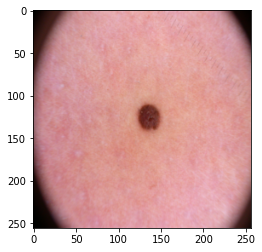

In [6]:
def to_img(ten):
    ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    ten=(ten*255).astype(np.uint8)
    return ten

a = to_img(x)
print(a.shape)
plt.imshow(a)

(256, 256, 1)


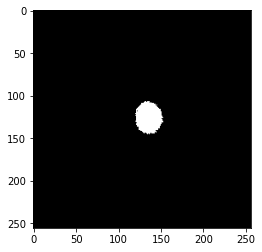

In [7]:
a = to_img(y)
print(a.shape)
plt.imshow(a, cmap='gray')

(256, 256, 3)


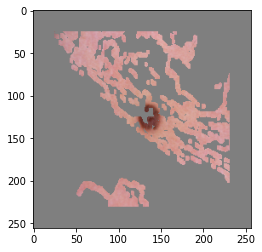

In [8]:
z = dt["partial_image1"]
a = to_img(z)
print(a.shape)
plt.imshow(a, cmap='gray')

(256, 256, 3)


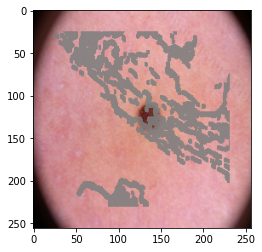

In [9]:
z = dt["partial_image2"]
a = to_img(z)
print(a.shape)
plt.imshow(a, cmap='gray')

## Load model

In [10]:
import torchvision

###### UNet model
#########################################################################################
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        # NOTE: 
        # nn.Conv2d(64, 1, kernel_size=1, padding=0) is mathematically same as 
        # nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs
    
    # def forward(self, x1, x2):
    #     out1 = self.forward_once(x1)
    #     out2 = self.forward_once(x2)
    #     return out1, out2
######################################################################################### 


# Define model
model = build_unet()

# Send to GPU
model = model.to(DEVICE)

In [11]:
model

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [12]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  31043521
Trainable parameters  31043521


## Setup optim and loss

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss() # loss combines a Sigmoid layer and the BCELoss in one single class

## Train and eval functions

In [14]:
def train(model, epoch):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        data1, data2, target = data["image"].to(DEVICE), data["partial_image1"].to(DEVICE), data["mask"].to(DEVICE)
        # This is siamese style U-Net
        # Pass two inputs through the same model to get two outputs
        output1 = model.forward(data1.float())
        output2 = model.forward(data2.float())

        # Compute loss based on two outputs
        # TODO: enforce similarity between output1 and output2
        loss1 = criterion(output1.float(), target.float())
        loss2 = criterion(output2.float(), target.float())
        
        # TODO: 
        # 1) add weight values between (0-1)
        # 2) loss2 high weight
        # more...
        loss = loss1 + loss2
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data))
            
def test(model):
    model.eval()
    
    with torch.no_grad():
        test_loss = 0
        jaccard = 0
        dice = 0

        for data in test_dataloader:
            data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            output = model(data.float())
            test_loss += criterion(output.float(), target.float()).item()
            
            output = torch.sigmoid(output) # Turn activations into probabilities by feeding through sigmoid
            gt = target.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy()
            pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5

            intersection = pred * gt
            union = pred + gt - intersection
            jaccard += (np.sum(intersection)/np.sum(union))  
            dice += (2. * np.sum(intersection) ) / (np.sum(pred) + np.sum(gt))
    
        test_loss /= len(test_dataloader)
        jaccard /= len(test_dataloader)
        dice /= len(test_dataloader)

        losses.append(test_loss)
        jacs.append(jaccard)
        dices.append(dice)


        print('Average Loss: {:.3f}'.format(test_loss))
        print('Jaccard Index : {:.3f}'.format(jaccard * 100))
        print('Dice Coefficient : {:.3f}'.format(dice * 100))
        print('==========================================')
        print('==========================================')
        return dice

## Train model

In [15]:
losses = []
jacs = []
dices = []

score = 0
best_score = 0

start_time = time.time()

N_EPOCHS = 5 # Do 100 or more!
 
for epoch in range(1, N_EPOCHS):
    print("Epoch: {}".format(epoch))
    train(model, epoch)
    score = test(model)
    
    # Save best model
    if score > best_score:
        print("Saving model at dice={:.3f}".format(score))
        torch.save(model.state_dict(), '{}/{}.pth'.format(LOG_PATH, EXPERIMENT_NAME))
        best_score = score

        
# Save losses
losses = np.array(losses)
np.savetxt("{}/{}_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), losses, delimiter=",")
jacs = np.array(jacs)
np.savetxt("{}/{}_jacs.txt".format(LOG_PATH, EXPERIMENT_NAME), jacs, delimiter=",")
dices = np.array(dices)
np.savetxt("{}/{}_dices.txt".format(LOG_PATH, EXPERIMENT_NAME), dices, delimiter=",")

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))
print("--- Time taken to train : %s mins ---" % ((end_time - start_time)//60))

Epoch: 1
Average Loss: 0.461
Jaccard Index : 33.206
Dice Coefficient : 45.171
Saving model at dice=0.452
Epoch: 2
Average Loss: 0.279
Jaccard Index : 67.850
Dice Coefficient : 77.567
Saving model at dice=0.776
Epoch: 3
Average Loss: 0.268
Jaccard Index : 69.625
Dice Coefficient : 79.389
Saving model at dice=0.794
Epoch: 4
Average Loss: 0.205
Jaccard Index : 75.096
Dice Coefficient : 83.909
Saving model at dice=0.839
--- Time taken to train : 0.0 hours ---
--- Time taken to train : 7.0 mins ---


In [16]:
best_score

0.8390927437552292

In [17]:
max(jacs), max(dices)

(0.7509550721517375, 0.8390927437552292)

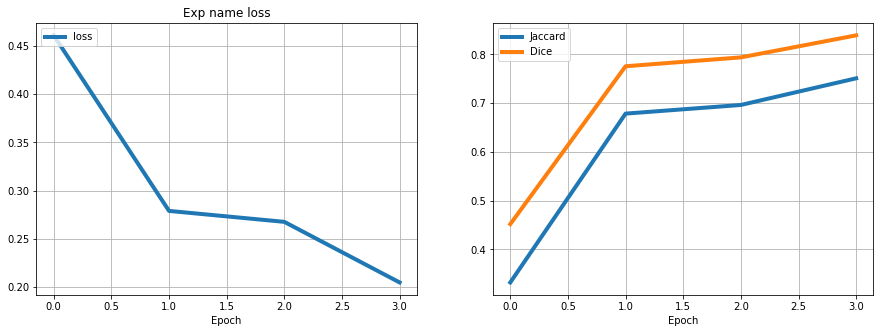

In [18]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(losses,linewidth=4)
plt.title('{} loss'.format("Exp name"))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')
plt.grid(True)
# Plot training & validation iou_score values
plt.subplot(122)
plt.plot(jacs,linewidth=4)
plt.plot(dices,linewidth=4)
#plt.title('{} IOU score'.format(experiment_name))
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Jaccard', 'Dice'], loc='upper left')
plt.savefig('{}/{}_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
plt.show()